In [14]:

from multiprocessing import Pool
from tqdm import tqdm
from spacy.lang.en import English
import gensim.corpora as corpora
from gensim.models import LdaMulticore
import multiprocessing as mp
import json
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import wordnet as wn
#nltk.download('stopwords')
#nltk.download('wordnet')
# spacy for lemmatization
import spacy
from spacy.lang.en import English
parser = English()

#Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
# Plotting tools

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


In [15]:
def tokenize(doc):
    tokens = doc.split(" ")
    tokens = [word for word in tokens if len(word.strip()) > 0]
    return tokens

print("Loading tech corpus")
with open("../data/tech_review_word_corpus.pkl","rb") as f:
    tech_review_corpus = pickle.load(f)
    
reviews = pd.DataFrame(tech_review_corpus).review.tolist()
print("Tokenize the corpus")

with open(( "../data/stop_words.json"), "r") as f:
    stop_words = json.load(f)

vectorizer = CountVectorizer( min_df = 5,max_df=.90, tokenizer=tokenize, stop_words=stop_words, ngram_range=(1, 2))



Loading tech corpus
Tokenize the corpus


In [16]:
X = vectorizer.fit_transform(reviews)
print("Total Vocab Size", len(vectorizer.vocabulary_))

Total Vocab Size 28211


In [17]:
from gensim.corpora.dictionary import Dictionary
def vect2gensim(vectorizer, dtmatrix):
     # transform sparse matrix into gensim corpus and dictionary
    corpus_vect_gensim = gensim.matutils.Sparse2Corpus(dtmatrix, documents_columns=False)
    dictionary = Dictionary.from_corpus(corpus_vect_gensim,
        id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))

    return (corpus_vect_gensim, dictionary)
corpus, id2word = vect2gensim(vectorizer, X)

In [18]:
final_lda_model = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=13, 
                                           random_state=100,
                                           chunksize=50,
                                           workers = 2,
                                           passes=10,
                                           alpha="asymmetric",
                                           eta=0.91,
                                           per_word_topics=True)

In [19]:
final_lda_model.save('../results/word-gensim-lda.model')

In [20]:
# Select the model and print the topics
optimal_model = final_lda_model
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.031*"work" + 0.030*"issue" + 0.027*"customer" + 0.020*"provide" + '
  '0.019*"learn" + 0.019*"environment" + 0.019*"client" + 0.015*"technology" + '
  '0.013*"management" + 0.013*"help" + 0.013*"train" + 0.012*"daily" + '
  '0.011*"problem" + 0.011*"service" + 0.010*"technical" + 0.010*"requirement" '
  '+ 0.009*"different" + 0.009*"skill" + 0.009*"process" + 0.009*"business" + '
  '0.008*"part" + 0.008*"need" + 0.008*"knowledge" + 0.008*"system" + '
  '0.007*"together" + 0.007*"quality" + 0.007*"ticket" + 0.007*"multiple" + '
  '0.007*"experience" + 0.007*"communication"'),
 (1,
  '0.055*"work" + 0.021*"people" + 0.020*"management" + 0.017*"employee" + '
  '0.017*"job" + 0.016*"year" + 0.012*"manager" + 0.012*"make" + 0.011*"time" '
  '+ 0.010*"great" + 0.010*"one" + 0.009*"like" + 0.008*"department" + '
  '0.008*"benefit" + 0.008*"position" + 0.008*"everything" + 0.007*"sure" + '
  '0.007*"pay" + 0.007*"everyone" + 0.006*"lot" + 0.006*"make sure" + '
  '0.006*"everyone work

In [21]:
lda_display = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

In [22]:
aspect = {}
for t in range(0, optimal_model.num_topics):
    aspect['topic {}: '.format(t)] = [v[0] for v in optimal_model.show_topic(t, 50)]

In [23]:
with open("../results/gensim/word-gensim-lda-topic-k-8.json", "w") as f:
                json.dump(aspect, f)

In [24]:
with open("../data/all_reviews.pkl","rb") as f:
    reviews_ = pickle.load(f)
    
job_filter = pd.read_csv("../data/filter_job_titles.csv")

job_filters = job_filter.clean_job_title.tolist()
idx = (reviews_.language == "en")
reviews_ = reviews_.loc[idx,:]

idx = (reviews_.clean_job_title.isin(job_filters))
reviews_ = reviews_.loc[idx,:].reset_index()

print(reviews_.shape)
#display(reviews_.head())


(45251, 16)


In [25]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=reviews):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=final_lda_model, corpus=corpus, texts=reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic["Review"] = reviews_["review"] 
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Review
0,0,8.0,0.5084,"care, good, job, employee, health, security, m...",fluor is great company with people that care t...,Fluor is a great company with people that care...
1,1,1.0,0.6521,"work, people, management, employee, job, year,...",fluor wa the first powerhouse epc that went he...,Fluor was the first powerhouse EPC that went h...
2,2,1.0,0.5822,"work, people, management, employee, job, year,...",there is not much that could add here enjoy wo...,There is not much that I could add here. I en...
3,3,5.0,0.3297,"time, claim, long, hour, done, manager, pretty...",the place can be pretty boring most of the tim...,The place can be pretty boring most of the tim...
4,4,1.0,0.5405,"work, people, management, employee, job, year,...",everyone is in hurry to get thing done but the...,"Everyone is in a hurry to get things done, but..."
5,5,1.0,0.4129,"work, people, management, employee, job, year,...",wa re hire first term would rate them they hir...,Was a re-hire. \rFirst term would rate them a...
6,6,1.0,0.7465,"work, people, management, employee, job, year,...",hate work for this company the pay wa great bu...,I hated working for this company. The pay was ...
7,7,2.0,0.3722,"work, great, learn, part, enjoy, place, job, l...",interesting day at work in enjoy environment u...,Interesting days at work in a enjoyable enviro...
8,8,7.0,0.4248,"project, typical, task, meeting, typical work,...",challenge place to work a it manager with five...,Challenging place to work as IT Manager with f...
9,9,1.0,0.4519,"work, people, management, employee, job, year,...",total of thirty seven 37 year of successful en...,Total of thirty-seven (37) years of successful...


In [28]:
df_dominant_topic.drop(columns="Text",inplace=True)

In [29]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Review
0,0,8.0,0.5084,"care, good, job, employee, health, security, m...",Fluor is a great company with people that care...
1,1,1.0,0.6521,"work, people, management, employee, job, year,...",Fluor was the first powerhouse EPC that went h...
2,2,1.0,0.5822,"work, people, management, employee, job, year,...",There is not much that I could add here. I en...
3,3,5.0,0.3297,"time, claim, long, hour, done, manager, pretty...",The place can be pretty boring most of the tim...
4,4,1.0,0.5405,"work, people, management, employee, job, year,...","Everyone is in a hurry to get things done, but..."
5,5,1.0,0.4129,"work, people, management, employee, job, year,...",Was a re-hire. \rFirst term would rate them a...
6,6,1.0,0.7465,"work, people, management, employee, job, year,...",I hated working for this company. The pay was ...
7,7,2.0,0.3722,"work, great, learn, part, enjoy, place, job, l...",Interesting days at work in a enjoyable enviro...
8,8,7.0,0.4248,"project, typical, task, meeting, typical work,...",Challenging place to work as IT Manager with f...
9,9,1.0,0.4519,"work, people, management, employee, job, year,...",Total of thirty-seven (37) years of successful...


In [32]:
with open("tech_review_with_topics.pkl","wb") as f:
    pickle.dump(df_dominant_topic, f)

In [33]:
df_dominant_topic.groupby('Dominant_Topic').size()

Dominant_Topic
0.0     3583
1.0    15399
2.0    11581
3.0     1835
4.0    11671
5.0      184
6.0       32
7.0       87
8.0      621
9.0      258
dtype: int64

### The most representative sentence for each topic¶

In [31]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9386,"work, issue, customer, provide, learn, environment, client, technology, management, help",tc is one of the best it company to work with it is having many client and different business fo...
1,1.0,0.9697,"work, people, management, employee, job, year, manager, make, time, great",all have to say is do not work here people are asset and should be treated a such instead they a...
2,2.0,0.9561,"work, great, learn, part, enjoy, place, job, lot, part job, hard",enjoy work at utdallas fun place to work very friendly co work and learn lot would suggest every...
3,3.0,0.9358,"development, system, report, application, software, user, using, implement, project, process",creating user interface using web form user control custom control validate control and validate...
4,4.0,0.9724,"work, good, life, balance, place, work life, life balance, good work, culture, environment",good company to work good work culture good company to work good work culture good company to wo...
5,5.0,0.6729,"time, claim, long, hour, done, manager, pretty, supportive, financial, paced",did not meet my expectation then it been very long time since work here the company ha been acqu...
6,6.0,0.6234,"personal, resource, stressful, structure, developing, value, fair, pto, plus, division",work more on applying the core value include respecting and accepting others a they are and not ...
7,7.0,0.6405,"project, typical, task, meeting, typical work, different, set, helped, strong, short",for the short time we were under the equifax umbrella the company wa very to u in the situation ...
8,8.0,0.8819,"care, good, job, employee, health, security, management, good management, job security, room",the management doe not care about employee well being
9,9.0,0.7966,"support, patient, call, information, computer, provide, engineer, health, insurance, center",the home is an american retailer of home improvement and construction product and service it ope...


### Sklearn Topic Modeling

In [4]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV 


In [6]:
vectorizer = CountVectorizer(min_df=3, token_pattern='[a-zA-Z0-9]{3,}')
data_vectorized = vectorizer.fit_transform(reviews)

In [7]:
data_vectorized.get_shape()

(45251, 8739)

In [20]:
# Define dictionaries for models and hyperparameters to be used in grid search evaluation:
lda = LatentDirichletAllocation(learning_method="online", verbose=1,random_state=100)
           

ParamDict = {"n_components": [7,8,9,10,11,12,13,14,15]
                     , "learning_decay": [.5, .7, .9]
                    }
                                    
gs = GridSearchCV(lda, ParamDict, cv=3, n_jobs=-1,
                              return_train_score='warn',pre_dispatch='2*n_jobs', refit=True
                              , verbose=1)
gs.fit(data_vectorized)




Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 15.2min finished


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


GridSearchCV(cv=3,
             estimator=LatentDirichletAllocation(learning_method='online',
                                                 random_state=100, verbose=1),
             n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [7, 8, 9, 10, 11, 12, 13, 14, 15]},
             return_train_score='warn', verbose=1)

In [22]:
# Best Model
best_lda_model = gs.best_estimator_
# Model Parameters
print("Best Model's Params for: ", gs.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", gs.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))  


Best Model's Params for:  {'learning_decay': 0.9, 'n_components': 7}
Best Log Likelihood Score:  -2125316.5700915544
Model Perplexity:  889.7745967579071


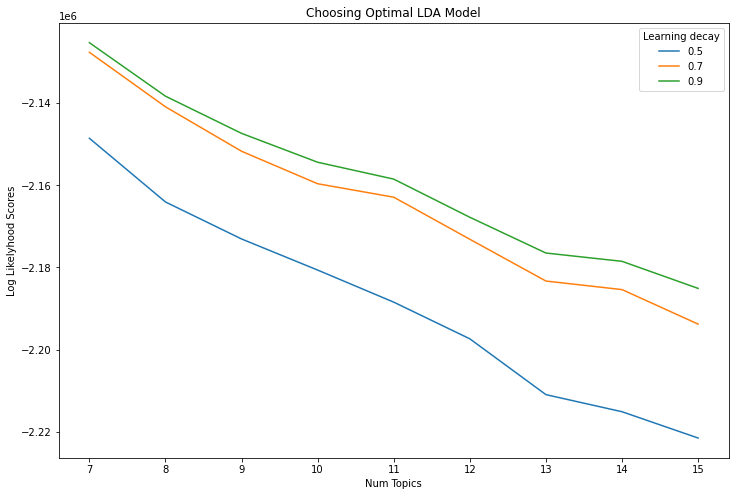

In [87]:
# Get Log Likelyhoods from Grid Search Output: Higher the better
n_topics = [7,8,9,10,11,12,13,14,15]
log_likelyhoods_5 = [round(i) for i in gs.cv_results_['mean_test_score'][0:9]]
log_likelyhoods_7 = [round(i) for i in gs.cv_results_['mean_test_score'][9:18]]
log_likelyhoods_9 = [round(i) for i in gs.cv_results_['mean_test_score'][18:27]]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [95]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(best_lda_model, vectorizer)
print("=" * 20)

LDA Model:
Topic 0:
[('manager', 1689.000347031121), ('get', 1637.2616350222534), ('time', 1489.235208537705), ('employee', 1364.0415502978326), ('management', 1170.8121413117367), ('month', 1025.2167663618518), ('work', 1022.9036072174354), ('like', 993.9566518357675), ('say', 830.6830608618918), ('job', 824.9761458519856)]
Topic 1:
[('system', 2040.2420263756073), ('issue', 1792.6798591555557), ('support', 1759.5949816425648), ('service', 1651.4965596369555), ('customer', 1403.9188076103108), ('application', 1339.0159202860698), ('work', 1253.4555691878402), ('software', 1136.3679232217703), ('network', 961.9725353997785), ('problem', 931.4944383216612)]
Topic 2:
[('work', 10085.649765021011), ('job', 5581.401432127152), ('part', 5484.064307205056), ('enjoy', 3978.3955219774343), ('management', 2918.1943373332283), ('worker', 2496.4480322930385), ('time', 2364.716940928196), ('hour', 2146.088104252344), ('hardest', 2074.5601012936622), ('always', 1999.4740637592383)]
Topic 3:
[('work

In [96]:
 
# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=7,init='nndsvd')
nmf_word = nmf_model.fit_transform(data_vectorized)
print(nmf_word.shape)  # (NO_DOCUMENTS, NO_TOPICS)

print(nmf_word[0])


(45251, 7)
[0.         0.         0.         0.06991709 0.08910744 0.03746602
 0.09107326]


In [97]:

 
print("NMF Model:")
print_topics(nmf_model, vectorizer)
print("=" * 20)
 

 

NMF Model:
Topic 0:
[('work', 20.927238702376304), ('life', 1.806457986905793), ('balance', 1.423943392262868), ('environment', 1.4048229803573034), ('culture', 1.1332362403675171), ('place', 1.1224275670137402), ('fun', 0.6899411298816617), ('hour', 0.6101939087322631), ('enjoy', 0.5222765467157835), ('friendly', 0.44080803192008844)]
Topic 1:
[('good', 15.752578928058288), ('place', 1.3015276237610185), ('culture', 1.1411506577223718), ('life', 1.1313355346749163), ('balance', 1.0666884798655027), ('salary', 0.7742363414808621), ('environment', 0.7402634720996671), ('benefit', 0.6399934422898467), ('opportunity', 0.603259661281471), ('experience', 0.531539604855103)]
Topic 2:
[('job', 10.806873863223423), ('part', 6.260830525854979), ('enjoy', 3.2898205940790026), ('hardest', 2.63817744435361), ('worker', 1.4318464296556215), ('customer', 1.3046067822874647), ('typical', 1.0601665534715679), ('would', 0.9524359210558091), ('security', 0.9307448268164324), ('issue', 0.9065601277044812

In [7]:
bigram_vectorizer = CountVectorizer(min_df=3, token_pattern='[a-zA-Z0-9]{3,}',ngram_range=(2,2))
data_bigram_vectorized = bigram_vectorizer.fit_transform(reviews)

In [8]:
data_bigram_vectorized.get_shape()

(45251, 48283)

In [9]:
# Define dictionaries for models and hyperparameters to be used in grid search evaluation:
lda = LatentDirichletAllocation(learning_method="online", verbose=1,random_state=100)
           

ParamDict = {"n_components": [7,8,9,10,11,12,13,14,15]
                     , "learning_decay": [.5, .7, .9]
                    }
                                    
gs = GridSearchCV(lda, ParamDict, cv=3, n_jobs=-1,
                              return_train_score='warn',pre_dispatch='2*n_jobs', refit=True
                              , verbose=1)
gs.fit(data_bigram_vectorized)



Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 101.9min finished


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


GridSearchCV(cv=3, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=100,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                               

In [10]:
# Best Model
best_lda_model = gs.best_estimator_
# Model Parameters
print("Best Model's Params for: ", gs.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", gs.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_bigram_vectorized))  


Best Model's Params for:  {'learning_decay': 0.9, 'n_components': 7}
Best Log Likelihood Score:  -1955395.0982904565
Model Perplexity:  22187.404928635824


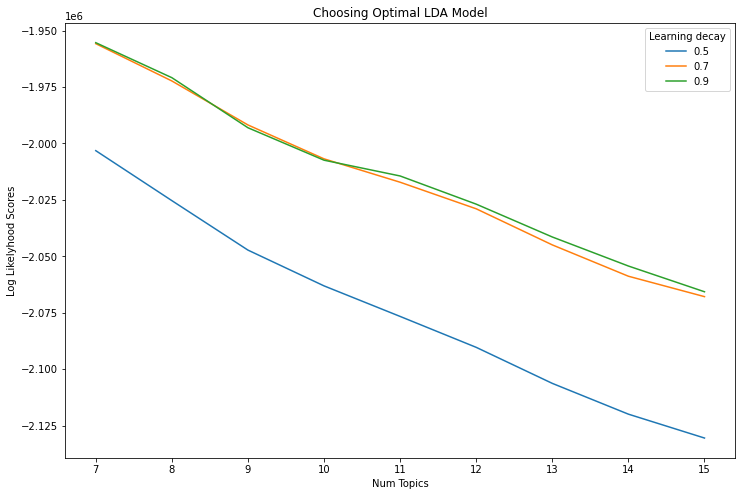

In [11]:
# Get Log Likelyhoods from Grid Search Output: Higher the better
n_topics = [7,8,9,10,11,12,13,14,15]
log_likelyhoods_5 = [round(i) for i in gs.cv_results_['mean_test_score'][0:9]]
log_likelyhoods_7 = [round(i) for i in gs.cv_results_['mean_test_score'][9:18]]
log_likelyhoods_9 = [round(i) for i in gs.cv_results_['mean_test_score'][18:27]]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [12]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(best_lda_model, bigram_vectorizer)
print("=" * 20)

LDA Model:
Topic 0:
[('working environment', 890.2835087387119), ('many thing', 734.2976911675795), ('friendly environment', 472.8473847721706), ('fun work', 400.961318973843), ('learned many', 388.81095392315575), ('personal life', 362.2351650502878), ('good working', 328.5446643212684), ('technical skill', 327.9937502215712), ('customer service', 305.0694024784411), ('great opportunity', 278.7194335468054)]
Topic 1:
[('work home', 804.1560659141974), ('nice place', 733.7019481220524), ('learn technology', 703.5492197869239), ('place work', 611.1498663748356), ('work culture', 496.37116074382755), ('full time', 404.7720754524957), ('great place', 320.2963125739208), ('project work', 309.2982673887064), ('opportunity grow', 307.63825894881023), ('work done', 261.59109193939236)]
Topic 2:
[('part job', 2642.032358633736), ('hardest part', 1965.7239655913875), ('enjoyable part', 1597.561834086457), ('learned lot', 882.1403099267513), ('typical work', 785.4545593167454), ('workplace cultu